In [65]:
import pandas as pd
from sklearn import svm

path = 'datasets/drug_consumption_engineered.csv'
dataset_D = pd.read_csv(path)

dataset_D.head()

,ID,Age,Gender,Education,Countery,Ethnicity,NScore,EScore,OScore,AScore,...,Cannabis,Cannabis_Consume,Choc,Choc_Consume,Ecstasy,Ecstasy_Consume,Nicotine,Nicotine_Consume,VSA,VSA_Consume
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,...,CL0,0,CL5,1,CL0,0,CL2,1,CL0,0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,...,CL4,1,CL6,1,CL4,1,CL4,1,CL0,0
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,...,CL3,1,CL4,1,CL0,0,CL0,0,CL0,0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,...,CL2,1,CL4,1,CL0,0,CL2,1,CL0,0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,...,CL3,1,CL6,1,CL1,0,CL2,1,CL0,0


In [66]:

selected_feature_columns = ['Age', 'Gender', 'Education', 'Countery', 'Ethnicity', 'NScore', 'EScore', 'OScore', 'AScore', 'CScore', 'Impulsive', 'SS']
selected_feature = dataset_D.loc[:, selected_feature_columns]
selected_feature.head()

,Age,Gender,Education,Countery,Ethnicity,NScore,EScore,OScore,AScore,CScore,Impulsive,SS
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575


In [67]:
selected_target = dataset_D.Cannabis_Consume
selected_target.head()

0    0
1    1
2    1
3    1
4    1
Name: Cannabis_Consume, dtype: int64

In [68]:
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn import preprocessing

db1_kfold = dataset_D.copy(deep=True)
selected_feature = db1_kfold.loc[:, selected_feature_columns]
selected_target = db1_kfold.Cannabis_Consume

preprocessing.MinMaxScaler()
selected_feature = preprocessing.MinMaxScaler().fit_transform(selected_feature)
print(selected_feature[0])



[0.40913683 1.         0.53768087 1.         0.4090609  0.5605621
 0.41211633 0.43568983 0.36765377 0.49904023 0.4284743  0.22439822]


In [69]:
from sklearn import tree 
dt_classifer_os = tree.DecisionTreeClassifier(min_samples_split=5, splitter="best", min_samples_leaf=50, criterion="entropy", min_weight_fraction_leaf=0.1, min_impurity_decrease=0.01)

k_fold_cv_os = KFold(n_splits=10)
smote_os = SMOTE()

dt_scores_os_recall_pos = []
dt_scores_os_precison_pos = []
dt_scores_os_recall_neg = []
dt_scores_os_precison_neg = []
results_os = pd.DataFrame()

for train_index, test_index in k_fold_cv_os.split(selected_feature, selected_target):
    train_selected_feature_fold, train_selected_target_fold = selected_feature[train_index], selected_target[train_index]
    test_selected_feature_fold, test_selected_target_fold = selected_feature[test_index], selected_target[test_index]

    train_selected_feature_os, train_selected_target_os = smote_os.fit_resample(train_selected_feature_fold, train_selected_target_fold)

    dt_model_os = dt_classifer_os.fit(train_selected_feature_os, train_selected_target_os)
    
    dt_scores_os_recall_pos.append(metrics.recall_score(test_selected_target_fold, dt_model_os.predict(test_selected_feature_fold), pos_label=1))
    dt_scores_os_precison_pos.append(metrics.precision_score(test_selected_target_fold, dt_model_os.predict(test_selected_feature_fold), pos_label=1))
    dt_scores_os_recall_neg.append(metrics.recall_score(test_selected_target_fold, dt_model_os.predict(test_selected_feature_fold), pos_label=0))
    dt_scores_os_precison_neg.append(metrics.precision_score(test_selected_target_fold, dt_model_os.predict(test_selected_feature_fold), pos_label=0))

results_os["dt_scores_os_recall_pos"] = dt_scores_os_recall_pos
results_os["dt_scores_os_precison_pos"] = dt_scores_os_precison_pos
results_os["dt_scores_os_recall_neg"] = dt_scores_os_recall_neg
results_os["dt_scores_os_precison_neg"] = dt_scores_os_precison_neg



In [70]:
from sklearn.tree import export_text

decision_text = export_text(dt_classifer_os, feature_names=selected_feature_columns)

print(decision_text)

|--- Countery <= 0.54
|   |--- Age <= 0.25
|   |   |--- class: 1
|   |--- Age >  0.25
|   |   |--- class: 1
|--- Countery >  0.54
|   |--- SS <= 0.54
|   |   |--- Age <= 0.41
|   |   |   |--- class: 0
|   |   |--- Age >  0.41
|   |   |   |--- class: 0
|   |--- SS >  0.54
|   |   |--- OScore <= 0.53
|   |   |   |--- class: 0
|   |   |--- OScore >  0.53
|   |   |   |--- class: 1



[Text(0.4090909090909091, 0.875, 'Countery <= 0.537\nentropy = 1.0\nsamples = 2242\nvalue = [1121, 1121]\nclass = y[0]'),
 Text(0.18181818181818182, 0.625, 'Age <= 0.249\nentropy = 0.707\nsamples = 795\nvalue = [153, 642]\nclass = y[1]'),
 Text(0.09090909090909091, 0.375, 'entropy = 0.367\nsamples = 555\nvalue = [39, 516]\nclass = y[1]'),
 Text(0.2727272727272727, 0.375, 'entropy = 0.998\nsamples = 240\nvalue = [114, 126]\nclass = y[1]'),
 Text(0.6363636363636364, 0.625, 'SS <= 0.537\nentropy = 0.916\nsamples = 1447\nvalue = [968, 479]\nclass = y[0]'),
 Text(0.45454545454545453, 0.375, 'Age <= 0.412\nentropy = 0.742\nsamples = 980\nvalue = [774, 206]\nclass = y[0]'),
 Text(0.36363636363636365, 0.125, 'entropy = 0.909\nsamples = 558\nvalue = [377, 181]\nclass = y[0]'),
 Text(0.5454545454545454, 0.125, 'entropy = 0.324\nsamples = 422\nvalue = [397, 25]\nclass = y[0]'),
 Text(0.8181818181818182, 0.375, 'OScore <= 0.527\nentropy = 0.979\nsamples = 467\nvalue = [194, 273]\nclass = y[1]'),
 

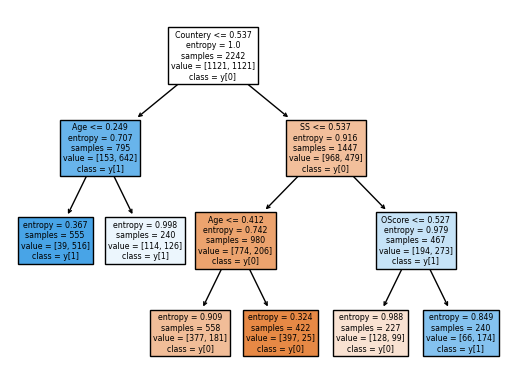

In [71]:
from sklearn import tree

tree.plot_tree(dt_classifer_os, feature_names=selected_feature_columns, filled=True, class_names=True)

0.7831261732311996
0.8109828174823773
0.6253427343401209
0.5659523236651267


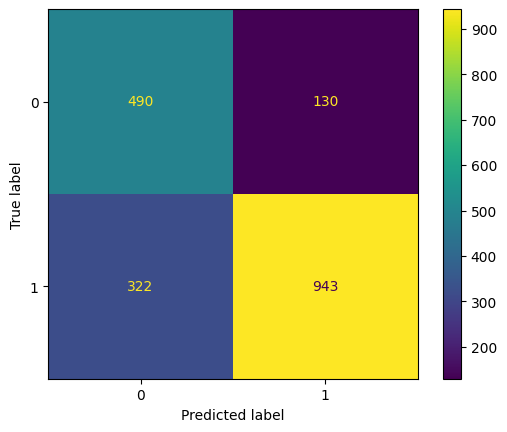

In [72]:
from sklearn import metrics

print(results_os["dt_scores_os_recall_pos"].mean())
print(results_os["dt_scores_os_precison_pos"].mean())
print(results_os["dt_scores_os_recall_neg"].mean())
print(results_os["dt_scores_os_precison_neg"].mean())

metrics.ConfusionMatrixDisplay.from_estimator(dt_classifer_os, selected_feature, selected_target)
